# Conda-Forge Graph networks with HoloViews+Bokeh+Datashader

[Datashader](http://datashader.readthedocs.org) makes it possible to plot very large datasets in a web browser, while [Bokeh](http://bokeh.pydata.org) makes those plots interactive, and [HoloViews](http://holoviews.org) provides a convenient interface for building these plots.

Here, let's use these three programs to visualize an example dataset of 16168 dependencies between 3742 conda-forge packages.

This notebook is entirely based on the datashader example of [UK Researcher's citation network.](http://datashader.org/topics/uk_researchers.html)

## First, we'll import the packages we are using and set up some defaults.


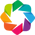

In [1]:
import os
import pandas as pd
import holoviews as hv
import networkx as nx

from colorcet import fire
from datashader.bundling import directly_connect_edges, hammer_bundle
from datashader.layout import random_layout, circular_layout, forceatlas2_layout

from holoviews.operation.datashader import datashade, dynspread
from holoviews.operation import decimate

from dask.distributed import Client
client = Client()

hv.notebook_extension('bokeh','matplotlib')

decimate.max_samples=20000
dynspread.threshold=0.01
datashade.cmap=fire[40:]
sz = dict(width=150,height=150)

%opts RGB [xaxis=None yaxis=None show_grid=False bgcolor="black"]

## Define helpful functions

In [2]:
# stackoverflow https://stackoverflow.com/questions/12329853/how-to-rearrange-pandas-column-sequence
# reorder columns
def set_column_sequence(dataframe, seq, front=True):
    '''Takes a dataframe and a subsequence of its columns,
       returns dataframe with seq as first columns if "front" is True,
       and seq as last columns if "front" is False.
    '''
    cols = seq[:] # copy so we don't mutate seq
    for x in dataframe.columns:
        if x not in cols:
            if front: #we want "seq" to be in the front
                #so append current column to the end of the list
                cols.append(x)
            else:
                #we want "seq" to be last, so insert this
                #column in the front of the new column list
                #"cols" we are building:
                cols.insert(0, x)
    return dataframe[cols]

### Convert the networkX graph to dataframes:

In [3]:
r_graph_file = os.getenv('CF_GRAPH')
r_graph = nx.read_yaml(r_graph_file)
pd_nodes = pd.DataFrame([(node, node) for node in r_graph.nodes], columns=['id', 'node'])
pd_nodes.set_index('id', inplace=True)
pd_edges = pd.DataFrame(list(r_graph.edges), columns=['source', 'target'])

### Layout the graph using datashader.layout

In [4]:
%time fa2_layout = forceatlas2_layout(pd_nodes, pd_edges)

CPU times: user 17.5 s, sys: 1.53 s, total: 19 s
Wall time: 17.6 s


### Back to HoloViews

In [5]:
r_nodes = hv.Points(set_column_sequence(fa2_layout, ['x', 'y']) , label='Nodes')
r_edges = hv.Curve(pd_edges, label='Edges')

We can render each dependency as a single-line direct connection, but the result is a dense tangle:

In [6]:
%%opts RGB [tools=["hover"] width=400 height=400] 

%time r_direct = hv.Curve(directly_connect_edges(r_nodes.data, r_edges.data),label="Direct")

dynspread(datashade(r_nodes,cmap=["cyan"])) + \
datashade(r_direct)

CPU times: user 543 ms, sys: 31.4 ms, total: 575 ms
Wall time: 554 ms


:Layout
   .DynamicMap.I  :DynamicMap   []
   .DynamicMap.II :DynamicMap   []

Detailed substructure of this graph becomes visible after bundling edges using a variant of [Hurter, Ersoy, & Telea (ECV-2012)](http://www.cs.rug.nl/~alext/PAPERS/EuroVis12/kdeeb.pdf), which takes a few seconds using multiple cores with [Dask](https://dask.pydata.org):

In [7]:
%time r_bundled = hv.Curve(hammer_bundle(r_nodes.data, r_edges.data),label="Bundled")

CPU times: user 2.7 s, sys: 2.42 s, total: 5.13 s
Wall time: 23.6 s


In [8]:
%%opts RGB [tools=["hover"] width=400 height=400] 

dynspread(datashade(r_nodes,cmap=["cyan"])) + \
datashade(r_bundled)

:Layout
   .DynamicMap.I  :DynamicMap   []
   .DynamicMap.II :DynamicMap   []

Zooming into these plots reveals interesting patterns (if you are running a live Python server), but immediately one then wants to ask what the various groupings of nodes might represent. With a small number of nodes or a small number of categories one could color-code the dots (using datashader's categorical color coding support), but here we just have thousands of indistinguishable dots. Instead, let's use hover information so the viewer can at least see the identity of each node on inspection.  

We can now overlay a set of points on top of the datashaded edges, which will provide hover information for each node.  Here, the entire set of 3000 nodes would be reasonably feasible to plot, but to show how to work with larger datasets we wrap the `hv.Points()` call with `decimate` so that only a finite subset of the points will be shown at any one time. If a node of interest is not visible in a particular zoom, then you can simply zoom in on that region; at some point the number of visible points will be below the specified decimate limit and the required point should be revealed.

In [9]:
%%opts Points (color="cyan", size=3) [tools=["hover"] width=900 height=650] 
datashade(r_bundled, width=900, height=650) * \
decimate(hv.Points(r_nodes),max_samples=1000)

:DynamicMap   []

If you click around and hover, you should see interesting groups of nodes, and can then set up further interactive tools using [HoloViews' stream support](http://holoviews.org/user_guide/Responding_to_Events.html) to reveal aspects relevant to your research interests or questions.

As you can see, datashader lets you work with very large graph datasets, though there are a number of decisions to make by trial and error, you do have to be careful when doing computationally expensive operations like edge bundling, and interactive information will only be available for a limited subset of the data at any one time due to data-size limitations of current web browsers.